# AMICI Python example "Boehm"

This is an example using the model [boehm_ProteomeRes2014.xml] model to demonstrate and test SBML import and AMICI Python interface.

In [1]:
import libsbml
import importlib
import amici
import pypesto
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# temporarily add the simulate file
sys.path.insert(0, 'boehm_JProteomeRes2014')

from benchmark_import import DataProvider

# sbml file
sbml_file = 'boehm_JProteomeRes2014/boehm_JProteomeRes2014.xml'

# name of the model that will also be the name of the python module
model_name = 'boehm_JProteomeRes2014'

# output directory
model_output_dir = 'tmp/' + model_name

## The example model

Here we use `libsbml` to show the reactions and species described by the model (this is independent of AMICI).

In [2]:
sbml_reader = libsbml.SBMLReader()
sbml_doc = sbml_reader.readSBML(os.path.abspath(sbml_file))
sbml_model = sbml_doc.getModel()
dir(sbml_doc)
print(os.path.abspath(sbml_file))
print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])


print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(),
                        reactants,
                        reversible,
                         products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))

/home/paul/Documents/pesto/pyPESTO/doc/example/boehm_JProteomeRes2014/boehm_JProteomeRes2014.xml
Species:  ['STAT5A', 'STAT5B', 'pApB', 'pApA', 'pBpB', 'nucpApA', 'nucpApB', 'nucpBpB']

Reactions:
v1_v_0:   2 STAT5A  ->      pApA		[cyt * BaF3_Epo * STAT5A^2 * k_phos]
v2_v_1:  STAT5A +  STAT5B  ->      pApB		[cyt * BaF3_Epo * STAT5A * STAT5B * k_phos]
v3_v_2:   2 STAT5B  ->      pBpB		[cyt * BaF3_Epo * STAT5B^2 * k_phos]
v4_v_3:       pApA  ->   nucpApA		[cyt * k_imp_homo * pApA]
v5_v_4:       pApB  ->   nucpApB		[cyt * k_imp_hetero * pApB]
v6_v_5:       pBpB  ->   nucpBpB		[cyt * k_imp_homo * pBpB]
v7_v_6:    nucpApA  ->  2 STAT5A		[nuc * k_exp_homo * nucpApA]
v8_v_7:    nucpApB  -> STAT5A +  STAT5B		[nuc * k_exp_hetero * nucpApB]
v9_v_8:    nucpBpB  ->  2 STAT5B		[nuc * k_exp_homo * nucpBpB]


## Importing an SBML model, compiling and generating an AMICI module

Before we can use AMICI to simulate our model, the SBML model needs to be translated to C++ code. This is done by `amici.SbmlImporter`.

In [3]:
# Create an SbmlImporter instance for our SBML model
sbml_importer = amici.SbmlImporter(sbml_file)

In this example, we want to specify fixed parameters, observables and a $\sigma$ parameter. Unfortunately, the latter two are not part of the [SBML standard](http://sbml.org/). However, they can be provided to `amici.SbmlImporter.sbml2amici` as demonstrated in the following.

### Constant parameters

Constant parameters, i.e. parameters with respect to which no sensitivities are to be computed (these are often parameters specifying a certain experimental condition) are provided as a list of parameter names.

In [4]:
constantParameters = {'ratio', 'specC17'}

### Observables

We used SBML's [`AssignmentRule`](http://sbml.org/Software/libSBML/5.13.0/docs//python-api/classlibsbml_1_1_rule.html) as a non-standard way to specify *Model outputs* within the SBML file. These rules need to be removed prior to the model import (AMICI does at this time not support these Rules). This can be easily done using `amici.assignmentRules2observables()`.

In this example, we introduced parameters named `observable_*` as targets of the observable AssignmentRules. Where applicable we have `observable_*_sigma` parameters for $\sigma$ parameters (see below).

In [5]:
# Retrieve model output names and formulae from AssignmentRules and remove the respective rules
observables = amici.assignmentRules2observables(
        sbml_importer.sbml, # the libsbml model object
        filter_function=lambda variable: variable.getId().startswith('observable_') and not variable.getId().endswith('_sigma')
    )
print('Observables:', observables)

Observables: {'observable_pSTAT5A_rel': {'name': '', 'formula': '(100 * pApB + 200 * pApA * specC17) / (pApB + STAT5A * specC17 + 2 * pApA * specC17)'}, 'observable_pSTAT5B_rel': {'name': '', 'formula': '-(100 * pApB - 200 * pBpB * (specC17 - 1)) / (STAT5B * (specC17 - 1) - pApB + 2 * pBpB * (specC17 - 1))'}, 'observable_rSTAT5A_rel': {'name': '', 'formula': '(100 * pApB + 100 * STAT5A * specC17 + 200 * pApA * specC17) / (2 * pApB + STAT5A * specC17 + 2 * pApA * specC17 - STAT5B * (specC17 - 1) - 2 * pBpB * (specC17 - 1))'}}


### $\sigma$ parameters

To specify measurement noise as a parameter, we simply provide a dictionary with (preexisting) parameter names as keys and a list of observable names as values to indicate which sigma parameter is to be used for which observable.

In [6]:
sigma_vals = ['sd_pSTAT5A_rel', 'sd_pSTAT5B_rel', 'sd_rSTAT5A_rel']
observable_names = observables.keys()
sigmas = dict(zip(list(observable_names), sigma_vals))
print(sigmas)

{'observable_pSTAT5A_rel': 'sd_pSTAT5A_rel', 'observable_pSTAT5B_rel': 'sd_pSTAT5B_rel', 'observable_rSTAT5A_rel': 'sd_rSTAT5A_rel'}


### Generating the module

Now we can generate the python module for our model. `amici.SbmlImporter.sbml2amici` will symbolically derive the sensitivity equations, generate C++ code for model simulation, and assemble the python module.

In [7]:
sbml_importer.sbml2amici(model_name,
                         model_output_dir,
                         verbose=False,
                         observables=observables,
                         constantParameters=constantParameters,
                         sigmas=sigmas
  )

### Importing the module and loading the model

If everything went well, we need to add the previously selected model output directory to our PYTHON_PATH and are then ready to load newly generated model:

In [8]:
sys.path.insert(0, os.path.abspath(model_output_dir))
model_module = importlib.import_module(model_name)

And get an instance of our model from which we can retrieve information such as parameter names:

In [9]:
model = model_module.getModel()

print("Model parameters:", list(model.getParameterIds()))
print("Model outputs:   ", list(model.getObservableIds()))
print("Model states:    ", list(model.getStateIds()))

Model parameters: ['Epo_degradation_BaF3', 'k_exp_hetero', 'k_exp_homo', 'k_imp_hetero', 'k_imp_homo', 'k_phos', 'sd_pSTAT5A_rel', 'sd_pSTAT5B_rel', 'sd_rSTAT5A_rel']
Model outputs:    ['observable_pSTAT5A_rel', 'observable_pSTAT5B_rel', 'observable_rSTAT5A_rel']
Model states:     ['STAT5A', 'STAT5B', 'pApB', 'pApA', 'pBpB', 'nucpApA', 'nucpApB', 'nucpBpB']


## Running simulations and analyzing results

After importing the model, we can run simulations using `amici.runAmiciSimulation`. This requires a `Model` instance and a `Solver` instance. Optionally you can provide measurements inside an `ExpData` instance, as shown later in this notebook.

In [10]:
h5_file = 'boehm_JProteomeRes2014/data_boehm_JProteomeRes2014.h5'
dp = DataProvider(h5_file)

In [11]:
# set timepoints for which we want to simulate the model
timepoints = amici.DoubleVector(dp.get_timepoints())
model.setTimepoints(timepoints)

# set fixed parameters for which we want to simulate the model
model.setFixedParameters(amici.DoubleVector(np.array([0.693, 0.107])))

# set parameters to optimal values found in the benchmark collection
model.setParameterScale(2)
model.setParameters(amici.DoubleVector(np.array([-1.568917588,
-4.999704894,
-2.209698782,
-1.786006548,
4.990114009,
4.197735488,
0.585755271,
0.818982819,
0.498684404
])))

# Create solver instance
solver = model.getSolver()

# Run simulation using model parameters from the benchmark collection and default solver options
rdata = amici.runAmiciSimulation(model, solver)

In [12]:
# Create edata
edata = amici.ExpData(rdata, 1.0, 0)

# set observed data
edata.setObservedData(amici.DoubleVector(dp.get_measurements()[0][:, 0]), 0)
edata.setObservedData(amici.DoubleVector(dp.get_measurements()[0][:, 1]), 1)
edata.setObservedData(amici.DoubleVector(dp.get_measurements()[0][:, 2]), 2)

# set standard deviations to optimal values found in the benchmark collection
edata.setObservedDataStdDev(amici.DoubleVector(np.array(16*[10**0.585755271])), 0)
edata.setObservedDataStdDev(amici.DoubleVector(np.array(16*[10**0.818982819])), 1)
edata.setObservedDataStdDev(amici.DoubleVector(np.array(16*[10**0.498684404])), 2)

In [13]:
rdata = amici.runAmiciSimulation(model, solver, edata)

print('Chi2 value reported in benchmark collection: 47.9765479')
print('chi2 value using AMICI:')
print(rdata['chi2'])

Chi2 value reported in benchmark collection: 47.9765479
chi2 value using AMICI:
47.97654457818761


## Run optimization using pyPESTO

In [14]:
# create objective function from amici model
# pesto.AmiciObjective is derived from pesto.Objective,
# the general pesto objective function class

model.requireSensitivitiesForAllParameters()


solver.setSensitivityMethod(amici.SensitivityMethod_forward)
solver.setSensitivityOrder(amici.SensitivityOrder_first)


objective = pypesto.AmiciObjective(model, solver, [edata], 1)

In [15]:
# create optimizer object which contains all information for doing the optimization
optimizer = pypesto.ScipyOptimizer()

optimizer.solver = 'bfgs'

In [16]:
# create problem object containing all information on the problem to be solved
x_names = ['x' + str(j) for j in range(0, 9)]
problem = pypesto.Problem(objective=objective,
                          lb=-5*np.ones((9)), ub=5*np.ones((9)),
                          x_names=x_names)

In [17]:
# do the optimization
result = pypesto.minimize(problem=problem,
                          optimizer=optimizer,
                          n_starts=10) # 200

## Visualization
Create waterfall and parameter plot

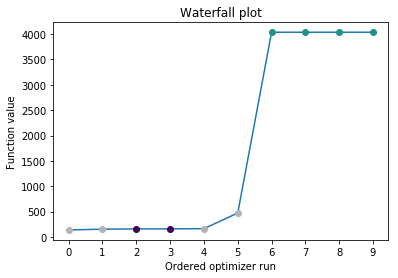

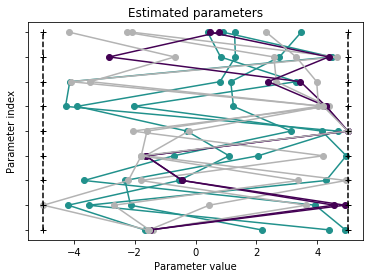

In [18]:
# waterfall, parameter space,
import pypesto.visualize

pypesto.visualize.waterfall(result)
pypesto.visualize.parameters(result)